# Analysing an Optical System 

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import meep as mp
import scipy.optimize as sc
from meep_optics import OpticalSystem, AsphericLens, ApertureStop, ImagePlane, Sim, Analysis

Let's look at the analysis of an optical system, which is essentially made by looking at the far field beam of the system. For that, we propagate a gaussian source from the image plane to the aperture, then take the fourier transform of the field at the aperture.

We need to use a focused system, one is given here with 2 aspheric lenses : 

In [3]:
lens1 = AsphericLens(name = 'Lens 1', 
                     r1 = 327.365, 
                     r2 = np.inf, 
                     c1 = -0.66067, 
                     c2 = 0, 
                     thick = 40, 
                     x = 130.+10., 
                     y = 0., 
                     AR_left = .5, AR_right = .5,
                     AR_delamination = 0.)
    
lens2 = AsphericLens(name = 'Lens 2', 
                     r1 = 269.190, 
                     r2 = 6398.02, 
                     c1 = -2.4029, 
                     c2 = 1770.36,
                     thick = 40, 
                     x = 40.+130.+369.408+10., 
                     y = 0.,
                     AR_left = .5, AR_right = .5,
                     AR_delamination = 0.)
    
aperture_stop = ApertureStop(name = 'Aperture Stop',
                             pos_x = 10,
                             diameter = 200,
                             thickness = 5,
                             n_refr = 1, 
                             conductivity = 100)
    
image_plane = ImagePlane(name = 'Image Plane',
                         pos_x = 10+714.704,
                         diameter = 300,
                         thickness = 2,
                         n_refr = 1.1, 
                         conductivity = 0.01)

We choose a wavelength of 10 so that it runs faster (because of the lower required resolution). The PML layer is fixed to half a wavelength.

In [4]:
wavelength = 10
res = 2
dpml = 5

Because the assembly process is always the same, let's wrap in a single function : 

In [5]:
def system_assembly(lens1, lens2, aperture_stop, image_plane, res, dpml):
    opt_sys = OpticalSystem('test')
    opt_sys.set_size(800,300)
    opt_sys.add_component(lens1)
    opt_sys.add_component(lens2)
    opt_sys.add_component(aperture_stop)
    opt_sys.add_component(image_plane)
    #print(opt_sys.list_components())
    
    
    opt_sys.assemble_system(dpml = dpml, resolution = res)
    opt_sys.write_h5file()
    
    return opt_sys

In [6]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = res, dpml = dpml)

Initialize the sim and the analysis :

In [7]:
sim = Sim(opt_sys)
analysis = Analysis(sim)

We make a gaussian beam on axis :

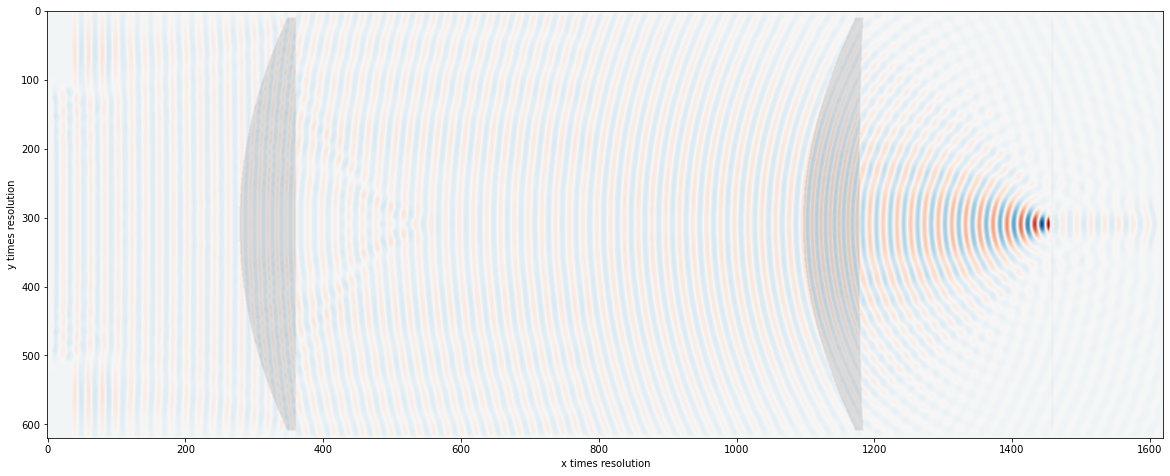

In [8]:
sim.define_source(wavelength = wavelength, sourcetype = 'Gaussian beam', 
                      x=754.704, y= 0, beam_width = 10, 
                      focus_pt_x= 0, focus_pt_y=0, size_x = 0, size_y=10)

sim.run_sim(runtime = 800, sim_resolution = res)
sim.plot_efield()

Now let's get the field evolution on the aperture :

In [10]:
aper_pos_x = 10
efield = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
n_iter = 100
e_field_evol = np.ones((n_iter, len(efield)))
e_field_evol[0] = efield


time = np.zeros(n_iter)
time[0] = sim.sim.meep_time()

for k in range(n_iter):
    sim.sim.run(until = .3)
    time[k] = sim.sim.meep_time()
    efield_k = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
    e_field_evol[k] = efield_k

The timestep is set at 0.3, it is below the lower threshold of 0.5 and MEEP uses the smallest possible timestep, which isn't exact, hence the time list taking the time in meep units

Here's the evolution of a single point of the aperture, just checking it's roughly a cosine :

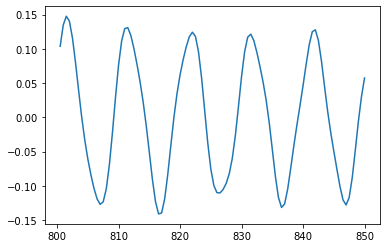

In [11]:
plt.plot(time, e_field_evol[:, 150*res])
plt.show()

We want to fit a cosine with an amplitude and a phase on that :

In [12]:
def f(x, amp, phase):
    return amp*np.cos(x*2*np.pi/wavelength + phase)

t = np.arange(n_iter)*.3
popt, pcov = sc.curve_fit(f, time, e_field_evol[:,150*res])#, p0 = [np.mean(np.abs(e_field_evol[:,150*res])), 0])
print(popt)

[-0.1255076   2.08117142]


Visually check the fit :

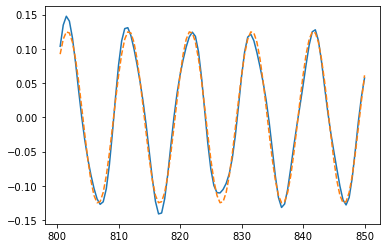

In [14]:
data = e_field_evol[:,150*res]
model = f(time, popt[0], popt[1])
plt.plot(time, data)
plt.plot(time, model, linestyle = '--')
plt.show()

Now fit all the points on the aperture and plot the amplitude of the cosines over the aperture :

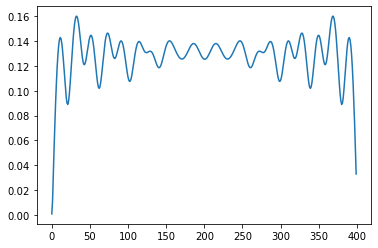

In [17]:
amplitude = np.zeros(200*res)
phase = np.zeros(200*res)
for k in range(200*res):
    popt, pcov = sc.curve_fit(f, time, e_field_evol[:,50*res+k])
    amplitude[k] = popt[0]
    phase[k] = popt[1]

plt.plot(np.arange(200*res), np.abs(amplitude))

The 'real' field is this amplitude, modulated by the cosine and looks like so : 

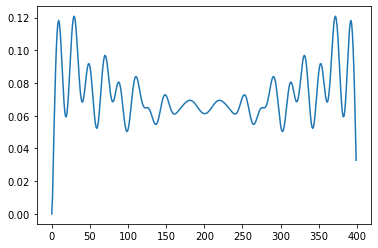

In [18]:
x = np.arange(200*res)
plt.plot(x, amplitude*np.cos(phase))

Now we can write the complex field on the aperture and use that in the Fourier Transform : 

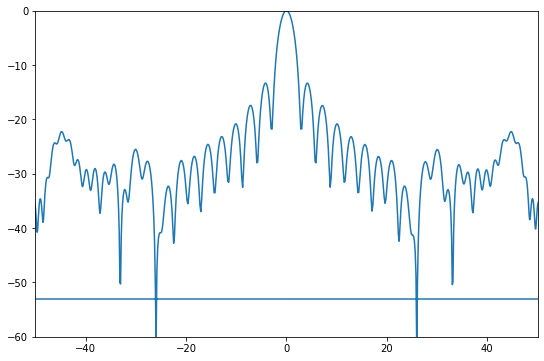

In [19]:
signal = amplitude*np.exp(1j*phase)

fft = np.fft.fft(signal, n = 15*len(signal))
freq = np.fft.fftfreq(15*len(signal), d = 1/res)

degrees = np.arctan(freq*wavelength)*180/np.pi

beam = fft*np.conj(fft)*(1+(freq*wavelength)**2)
fft_dB = 10*np.log10(np.abs(beam.real/np.max(beam.real)))

plt.figure(figsize = (9,6))
plt.plot(degrees, fft_dB)
plt.xlim((-50,50))
plt.ylim((-60,0))
plt.show()

Checking that the beam FWHM is given by $\frac{\lambda}{D}$ : 

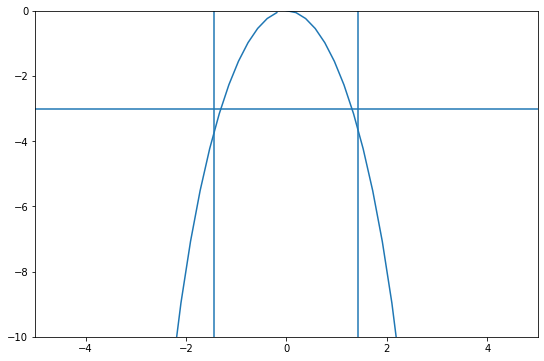

In [21]:
plt.figure(figsize = (9,6))
plt.plot(degrees, fft_dB)
plt.xlim((-5,5))
plt.ylim((-10,0))
plt.hlines(10*np.log10(.5), -5, 5)
plt.vlines([-wavelength*180/(2*200*np.pi), wavelength*180/(2*200*np.pi)], -10, 0)
plt.show()

Let's try the same thing for a source off axis and check that the far field beam is indeed at an angle : 

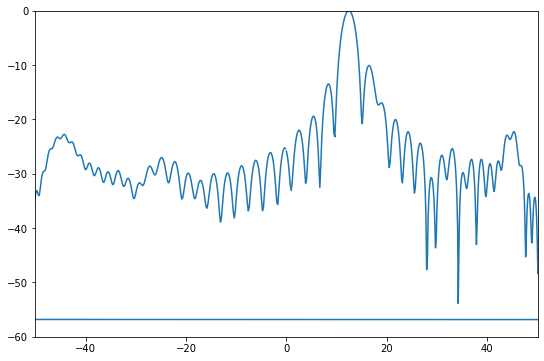

In [29]:
#SIM
sim.define_source(wavelength = wavelength, sourcetype = 'Gaussian beam', 
                      x=754.704, y= 100, beam_width = 10, 
                      focus_pt_x= 0, focus_pt_y=0, size_x = 0, size_y=10)

sim.run_sim(runtime = 800, sim_resolution = res)

#FIELD EVOLUTION
aper_pos_x = 10
efield = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
n_iter = 100
e_field_evol = np.ones((n_iter, len(efield)))
e_field_evol[0] = efield


time = np.zeros(n_iter)
time[0] = sim.sim.meep_time()

for k in range(n_iter):
    sim.sim.run(until = .3)
    time[k] = sim.sim.meep_time()
    efield_k = sim.sim.get_array(center=mp.Vector3(-sim.opt_sys.size_x/2+aper_pos_x, 0), 
                                         size=mp.Vector3(0, sim.opt_sys.size_y), component=mp.Ez)
    e_field_evol[k] = efield_k

#FITTING
def f(x, amp, phase):
    return amp*np.cos(x*2*np.pi/wavelength + phase)

amplitude = np.zeros(200*res)
phase = np.zeros(200*res)
for k in range(200*res):
    popt, pcov = sc.curve_fit(f, time, e_field_evol[:,50*res+k])
    amplitude[k] = popt[0]
    phase[k] = popt[1]
    
#FFT
signal = amplitude*np.exp(1j*phase)

fft = np.fft.fft(signal, n = 15*len(signal))
freq = np.fft.fftfreq(15*len(signal), d = 1/res)

degrees = np.arctan(freq*wavelength)*180/np.pi

beam = fft*np.conj(fft)*(1+(freq*wavelength)**2)
fft_dB = 10*np.log10(np.abs(beam.real/np.max(beam.real)))

plt.figure(figsize = (9,6))
plt.plot(degrees, fft_dB)
plt.xlim((-50,50))
plt.ylim((-60,0))
plt.show()

Now let's show how this analysis is done with the code (i.e. not by hand) :

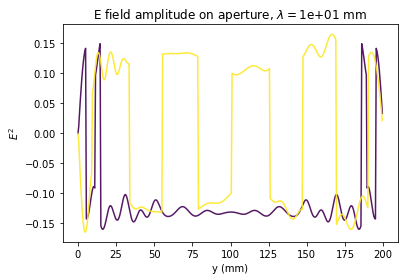

In [36]:
opt_sys = system_assembly(lens1, lens2, aperture_stop, image_plane, res = res, dpml = dpml)
sim = Sim(opt_sys)
analysis2 = Analysis(sim)
analysis2.image_plane_beams(wavelength = wavelength, sourcetype='Gaussian beam',
                                y_max = 100, Nb_sources = 2, sim_resolution = 2)

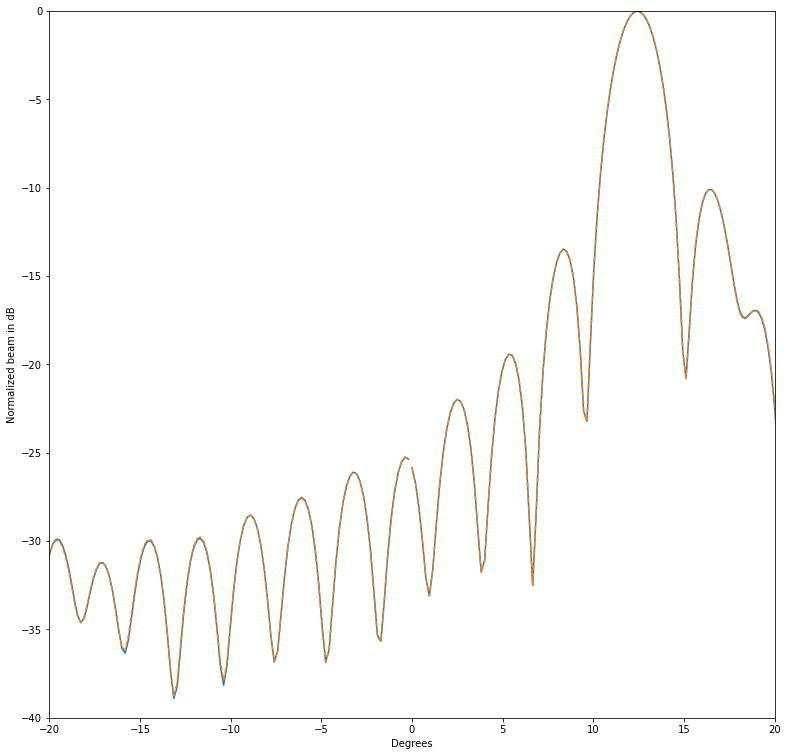

In [42]:
freq_code, fft_code = analysis2.beam_FT(aperture_size = 200, precision_factor = 15)
degrees_code = np.arctan(freq_code*wavelength)*180/np.pi
#We take the 2nd beam, because the code runs multiple beams ranging from 0 to ymax distance from optical axis and we are interested in the last one
fft_dB_code = 10*np.log10(np.abs(fft_code[1]))
plt.figure(figsize = (13,13))
plt.plot(degrees, fft_dB)
plt.plot(degrees_code, fft_dB_code, linestyle = '--')
plt.ylim((-40, 0))
plt.xlim((-20,20))
plt.xlabel('Degrees')
plt.ylabel('Normalized beam in dB')
plt.savefig('Analysis_check')
plt.show()

The analysis in the meep_optics.py code works as expected ! 

Now it is possilbe to modify the system and add defects etc... and see the impact on the far field beam.

# FFT tests

Just a few tests, ignore that.

/home/alexei/miniconda3/envs/mp/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


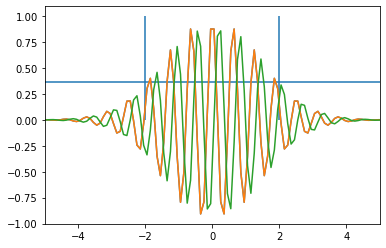

In [69]:
x = np.linspace(-50,50, 1000)
sigma = 2
s = np.exp(-x**2/(sigma**2))*(np.exp(1j*x*10))
s2 = np.exp(-x**2/(sigma**2))*np.cos(x*10)
plt.plot(x,s.real)
plt.plot(x, s2)

plt.vlines((-2,2), 0, 1)
plt.hlines(1-0.632, -5, 5)
plt.xlim(-5,5)
plt.show()

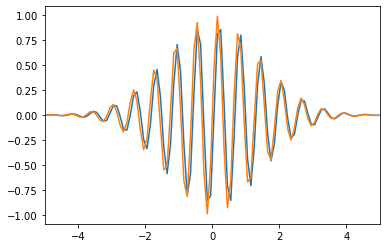

In [73]:
diff = np.diff(s.real)
diff = np.append(0, diff)
plt.plot(x, -diff)
plt.plot(x, s.imag)
plt.xlim(-5,5)
plt.show()

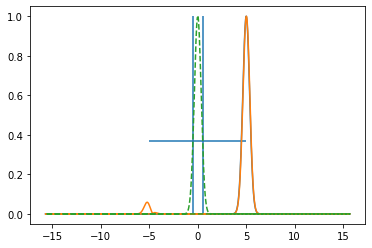

In [191]:
s_fft = np.fft.fft(s, n = 1*len(s))
s_fft2 = np.fft.fft(s2-1j*diff, n= 1*len(s))
freq = np.fft.fftfreq(1000*1, d = 0.1)*np.pi
amp = np.abs(s_fft.real)
plt.plot(freq, amp/max(amp))
plt.plot(freq, np.abs(s_fft2.real/max(s_fft2.real)))
plt.plot(freq, np.exp(-(freq*sigma)**2), linestyle = '--')
plt.vlines((-1/2,1/2), 0, 1)
plt.hlines(1-0.632, -5, 5)
#plt.xlim((-1,1))
plt.show()

/home/alexei/miniconda3/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


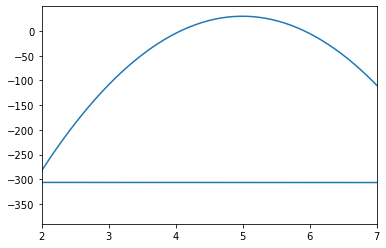

In [192]:
pouet = 10*np.log10(s_fft.real**2)
plt.plot(freq, pouet)
plt.xlim((2,7))
plt.show()